# xarray and pandas accessors

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eserie/wax-ml/blob/main/docs/notebooks/01_demo_EWMA.ipynb)

WAX implements pandas and xarray "accessors" to ease the usage of machine-learning algorithms with
high-level data APIs :
- pandas's `DataFrame` and `Series` and
- xarray's `Dataset` and `DataArray`.

These accessors allow to easily execute any function using Haiku modules
on these data containers.

For instance, WAX propose an implementation of the exponential moving average realized
with this mechanism.

Let's show how it works.

## Load accessors

First you need to load accessors:

In [1]:
from wax.accessors import register_wax_accessors

register_wax_accessors()

## EWMA on dataframes

Let's look at a simple example: The exponential moving average (EWMA).

Let's apply the EWMA algorithm to the [NCEP/NCAR 's Air temperature data](http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.html).

### 🌡 Load temperature dataset 🌡

In [2]:
import xarray as xr

da = xr.tutorial.open_dataset("air_temperature")

Let's see what this dataset looks like:

In [3]:
da

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

To compute a EWMA on some variables of a dataset, we usually need to convert data
in pandas
[series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) or
[dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

So, let's convert the dataset into a dataframe to illustrate `accessors` on a dataframe:

In [4]:
dataframe = da.air.to_series().unstack(["lon", "lat"])

### EWMA with pandas

CPU times: user 360 ms, sys: 37.7 ms, total: 398 ms
Wall time: 406 ms


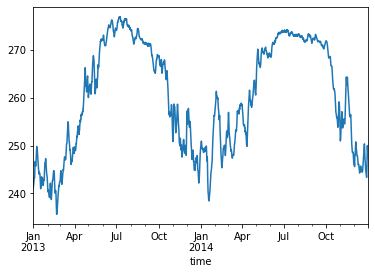

In [5]:
%%time
air_temp_ewma = dataframe.ewm(alpha=1.0 / 10.0).mean()
_ = air_temp_ewma.iloc[:, 0].plot()

### EWMA with WAX

CPU times: user 1.54 s, sys: 349 ms, total: 1.89 s
Wall time: 1.89 s


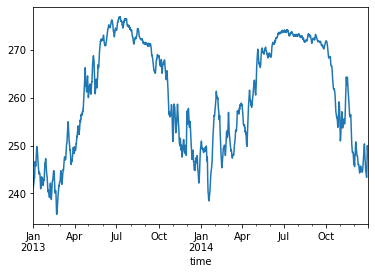

In [6]:
%%time
air_temp_ewma = dataframe.wax.ewm(alpha=1.0 / 10.0).mean()
_ = air_temp_ewma.iloc[:, 0].plot()

On small data, WAX's EWMA is slower than Pandas' because of the expensive data conversion steps.
WAX's accessors are interesting to use on large data loads
(See our [three-steps_workflow](https://wax-ml.readthedocs.io/en/latest/notebooks/04_The_three_steps_workflow.html))

## Apply a custom function to a Dataset

Now let's illustrate how WAX accessors work on [xarray datasets](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).

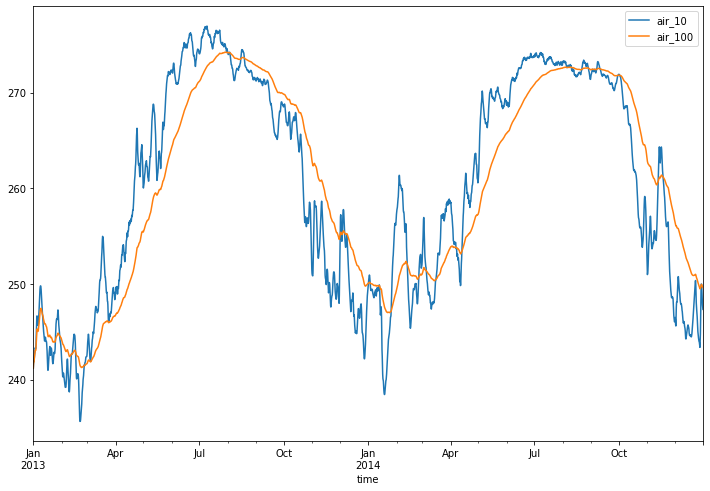

In [7]:
from wax.modules import EWMA


def my_custom_function(da):
    return {
        "air_10": EWMA(1.0 / 10.0)(da["air"]),
        "air_100": EWMA(1.0 / 100.0)(da["air"]),
    }


da = xr.tutorial.open_dataset("air_temperature")
output, state = da.wax.stream().apply(my_custom_function, format_dims=da.air.dims)

_ = output.isel(lat=0, lon=0).drop(["lat", "lon"]).to_pandas().plot(figsize=(12, 8))